# Проект 3 - Рыночная стоимость объектов недвижимости

## Введение

**Описание проекта**

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.

Задача — установить параметры для определения рыночной стоимости объектов недвижимости. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных: первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Описание данных**

В таблице 22 столбца:

1. `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
2. `balcony` — число балконов
3. `ceiling_height` — высота потолков (м)
4. `cityCenters_nearest` — расстояние до центра города (м)
5. `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
6. `first_day_exposition` — дата публикации
7. `floor` — этаж
8. `floors_total` — всего этажей в доме
9. `is_apartment` — апартаменты (булев тип)
10. `kitchen_area` — площадь кухни в квадратных метрах (м²)
11. `last_price` — цена на момент снятия с публикации
12. `living_area` — жилая площадь в квадратных метрах (м²)
13. `locality_name` — название населённого пункта
14. `open_plan` — свободная планировка (булев тип)
15. `parks_around3000` — число парков в радиусе 3 км
16. `parks_nearest` — расстояние до ближайшего парка (м)
17. `ponds_around3000` — число водоёмов в радиусе 3 км
18. `ponds_nearest` — расстояние до ближайшего водоёма (м)
19. `rooms` — число комнат
20. `studio` — квартира-студия (булев тип)
21. `total_area` — площадь квартиры в квадратных метрах (м²)
22. `total_images` — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, которые не относятся к жилому фонду, но имеют необходимые условия для проживания.

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Простые артефакты
2. Пропущенные значения и типы данных

Пойдем по порядку.

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Я привык сохранять исходный датасет, чтобы можно было проследить какие преобразования были совершены.
raw_properties = pd.read_csv('raw_real_estate.csv', sep='\t')
df_properties = raw_properties.copy()

# Посмотрим размеры датасета
print('-' * 50)
print('Размер датасета (строки, столбцы):', df_properties.shape)
print('-' * 50)

# Выведем на экран информацию о датасете
df_properties.info()

--------------------------------------------------
Размер датасета (строки, столбцы): (23699, 22)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          2

Во-первых, колонки уже имеют более-менее нормальный тип данных (целочисленное количество этажей `floor`, например). За исключением `is_apartment`, которая явно должна быть `bool`, а также парочки других виноватых.

Во-вторых, колонки имеют разное количество строк. Это говорит о том, что некоторые значения отсутствуют.

В-третьих, непохоже, что у нас нет идентификаторов категорий, которые можно вынести в отдельные словари.

Наконец, я вижу, что у нас три типа колонок: данные о квартире, данные о локации и данные об объявлении. Сгруппируем их, чтобы было хотя бы понятно с чего начать.

In [83]:
# Причешем это безобразие
df_properties.rename(columns={'cityCenters_nearest': 'city_center_nearest',
                              'studio': 'is_studio',
                              'open_plan': 'is_open_plan',
                              'locality_name': 'location_name',
                              'ponds_around3000': 'ponds_around_3km',
                              'parks_around3000': 'parks_around_3km'}, inplace=True)

# Сделаем словарь типов колонок.
# Потом пригодится, чтобы смотреть данные выборочно
column_list = {'apartment': ['total_area',
                             'living_area',
                             'kitchen_area',
                             'rooms',
                             'balcony',
                             'ceiling_height',
                             'floors_total',
                             'floor',
                             'is_apartment',
                             'is_studio',
                             'is_open_plan'],

               'location': ['location_name',
                            'city_center_nearest',
                            'airports_nearest',
                            'parks_nearest',
                            'ponds_nearest',
                            'parks_around3000',
                            'ponds_around3000'],

               'ads': ['total_images',
                       'last_price',
                       'first_day_exposition',
                       'days_exposition']}

# Выведем на экран первые строчки
display(df_properties.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,location_name,airports_nearest,city_center_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


По первым 10 строчкам уже видно, что нас ждут приключения!

### Простые артефакты

В наших данных есть небольшое количество строк с явно странными значениями, которые будут дальше мешать нам жить.

In [84]:
# Посмотрим, что за значения внутри
display(round(df_properties[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()))

,total_area,last_price,rooms,ceiling_height
count,23699.0,23699.0,23699.0,14504.0
mean,60.0,6541549.0,2.0,3.0
std,36.0,10887013.0,1.0,1.0
min,12.0,12190.0,0.0,1.0
25%,40.0,3400000.0,1.0,3.0
50%,52.0,4650000.0,2.0,3.0
75%,70.0,6800000.0,3.0,3.0
max,900.0,763000000.0,19.0,100.0


Сразу видно виноватых: у нас есть `total_area` почти 900 м^2, `last_price` в 763М рублей (!), и `ceiling_height` 100 м. Первые два артефакта, скорей всего, настоящие квартиры, просто очень большие. Последний же артефакт - явно ошибка.

Посмотрим как это выглядит на графиках.

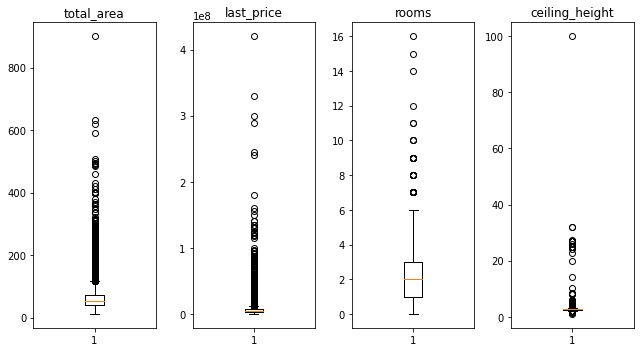

In [85]:
def fun_get_boxplots_for_columns(df, columns, num_rows, num_columns):
    """
    This function creates a num_rows x num_columns box subplots for a list of columns out of the dataset.

    Args:
        df (DataFrame): dataframe with data to show
        columns (List): list of columns to plot
        num_rows (int): number of rows in subplots
        num_columns (int): number of columns in subplots
    """
    # Для начала коробки с усами
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(9, 5))

    # Добавим каждый бокс-с-усами к фигуре
    for i, ax in enumerate(axs.flat):
        ax.boxplot(df[columns].dropna().iloc[:, i])
        ax.set_title(df[columns].columns[i])

    # Сделаем нормальный формат графиков и удалим ненужные переменные
    plt.tight_layout()


fun_get_boxplots_for_columns(
    df_properties, ['total_area', 'last_price', 'rooms', 'ceiling_height'], 1, 4)

У нас очень много выбивающихся значений!
1. С `total_area` ситуация выглядит более-менее правдоподобно - у нас могут быть квартиры любого размера.
2. В `rooms` у нас есть нули - это, вероятно квартиры-студии. Сделаем их всех однокомнатными. Также у нас есть квартиры-отели с более чем 10 комнатами. Избавимся от них тоже.
3. У `last_price` есть длинный хвост из больших и редких значений - я думаю, что его надо обрезать где-то на `5e7` (это также обрежет все остальные колонки).
4. Наконец, `ceiling_height` тоже странный хвост из значений более 5 метров. Их мы тоже обрежем, т.к. нас не интересуют ангары в этом упражнении.

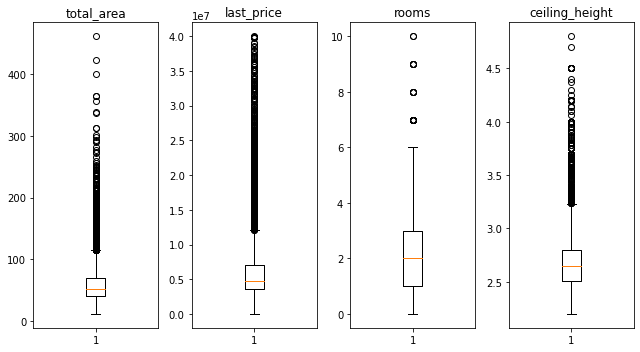

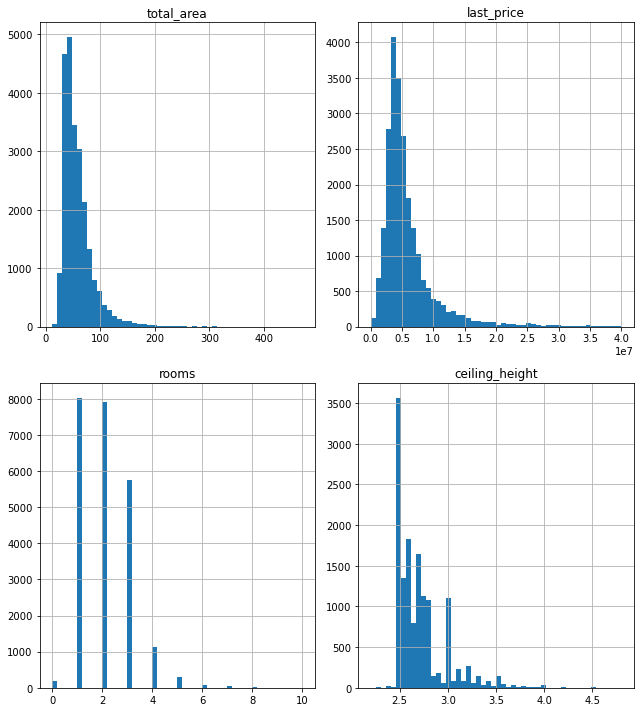

In [86]:
# Уберем странные значения из ceiling_height
df_properties = df_properties[(df_properties.ceiling_height < 5) &
                              (df_properties.ceiling_height > 2) |
                              (df_properties.ceiling_height.isna())]

# Уберем странные значения из last_price
df_properties = df_properties[df_properties.last_price < 4e7]

# Уберем странные значения к rooms
df_properties = df_properties[df_properties.rooms <= 10]

# Посмотрим на новую коробку-с-усами
fun_get_boxplots_for_columns(df_properties, ['total_area', 'last_price', 'rooms', 'ceiling_height'], 1, 4)

# Посмотрим на гистрограммы: площадь, цена, число комнат, высота потолков
df_properties[['total_area', 'last_price', 'rooms', 'ceiling_height']].hist(bins=50, figsize=(9, 10))

# Нормальный формат графика
plt.tight_layout()

### Пропущенные значения и типы данных

Сначала разберемся с попущенными значениями - глядишь, некоторые из них можно восстановить.

In [87]:
# Найдем колонки с пропущенными значениями через функцию - нам надо будет сделать это пару раз
def fun_get_columns_with_nan(df):
    """
    This function returns a list of column names, which have NaN values from an input data frame.

    Args:
        df (DataFrame): A dataframe to check

    Returns:
        columns_with_nan (list): A list of column names which have NaNs inside 
    """
    # Пустой лист
    columns_with_nan = []

    # Найдем виноватых
    for column in df.columns:
        if df[column].isna().sum() > 0:
            columns_with_nan.append(column)
    return columns_with_nan


# Посмотрим на них
display(df_properties[fun_get_columns_with_nan(df_properties)].head())

,ceiling_height,floors_total,living_area,is_apartment,kitchen_area,balcony,location_name,airports_nearest,city_center_nearest,parks_around_3km,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition
0,2.70,16.0,51.0,NaN,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,NaN,11.0,18.6,NaN,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,NaN,5.0,34.3,NaN,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
4,3.03,14.0,32.0,NaN,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,NaN,12.0,14.4,NaN,9.1,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0


Начнем заполнять. `is_apartment` - думаю, правильно предположить, что если `NaN`, то значение должно быть `False`. Количество балконов `balcony`, если не указано, что, вероятно, равно нулю.

`ceiling_height`, `kitchen_area` и `living_area` можно попробовать вычислить как пропорциональные значения от суммарной площади квартиры `total_area` в зависимости от количества комнат.

Наконец, `floors_total`, `location_name` и `days_exposition` - придется оставить пустыми. Значения в этих колонках нельзя найти логическими путями и они не зависят от других колонок.

Скорей всего, человек просто не ввел все эти данные, когда оставлял объявление.

Колонку `city_center_nearest` придется тоже оставить в покое, т.к. точного адреса у нас нет. Видимо, автоматические алгоритмы не определили какой город ближайший.

Остальные колонки `airports_nearest`, `parks_around_3km`, `parks_nearest`, `ponds_around_3km`, `ponds_nearest` мы убьем, потому что в задании они не используются.

In [88]:
# Уберем колонки, которые не нужны
df_properties.drop(['airports_nearest',
                    'parks_around_3km',
                    'parks_nearest',
                    'ponds_around_3km',
                    'ponds_nearest'], axis=1, inplace=True)

Разберемся с пропусками.

In [91]:
# Eсли пусто - сделаем False для is_apartment
df_properties.is_apartment.fillna(False, inplace=True)

# Если пусто - сделаем 0 для balcony
df_properties.balcony.fillna(0, inplace=True)

# Если ноль - сделаем 1 для rooms
df_properties.rooms.replace(0, 1, inplace=True)

# Разберемся с ceiling_height
df_properties.ceiling_height.fillna(df_properties
                                    .groupby('rooms')
                                    .ceiling_height
                                    .transform('mean'), inplace=True)

# Найдем какую долю от общей площади составляют living_area & kitchen_area
df_properties['living_to_total_area'] = df_properties.living_area / df_properties.total_area
df_properties['kitchen_to_total_area'] = df_properties.kitchen_area / df_properties.total_area

# Заполним пропущенные значения для living_to_total_area и kitchen_to_total_area
df_properties.living_to_total_area.fillna(df_properties
                                    .groupby('rooms')
                                    .living_to_total_area
                                    .transform('mean'), inplace=True)

df_properties.kitchen_to_total_area.fillna(df_properties
                                    .groupby('rooms')
                                    .kitchen_to_total_area
                                    .transform('mean'), inplace=True)

# Заполним пропущенные значения для living_area и kitchen_area
df_properties.living_area.fillna( df_properties.living_to_total_area * df_properties.total_area, inplace=True )
df_properties.kitchen_area.fillna( df_properties.kitchen_to_total_area * df_properties.total_area, inplace=True )

# Посмотрим что получилось
print('Количество пропущенных значений, которые вырезали из датасета:',
      len(raw_properties) - len(df_properties))
print('Доля пропущенных значений, которые вырезали из датасета:',
      round(len(df_properties) / len(raw_properties), 2), '%' )
print('Количество пропущенных значений, которые оставили в датасете:')
print(df_properties[fun_get_columns_with_nan(df_properties)].isna().sum())

Количество пропущенных значений, которые вырезали из датасета: 247
Доля пропущенных значений, которые вырезали из датасета: 0.99 %
Количество пропущенных значений, которые оставили в датасете:
floors_total             85
location_name            49
city_center_nearest    5495
days_exposition        3127
dtype: int64


In [90]:
# display(df_properties.isna())

#df_properties[column_list['location']].plot( kind='box', subplots=True, layout=(2, 4), figsize=(10, 10) );
